<a href="https://colab.research.google.com/github/romiebanerjee/laplace/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laplace-BNN inference with KFAC posterior and GLM predictive

**Author**: Romie Banerjee
<!-- **Last Updated**: `YYYY-MM-DD`   -->

---

## 1. Overview
A tutorial on Laplace-BNN inference. Focus on calculating the *GLM predictive*. The posterior is calculated using KFAC.

## 2. BNN
A **Bayesian neural network (BNN)** is an infinite family of neural networks, parametrized as a map $f:X \times \Theta \to Y$, where the spaces  $X$, $\Theta$ and $Y$ are respectively the imput, model and output spaces. The mapping is coordinatized as $R^n \times R^w \to R^d$. The mapping $(x, \theta) \mapsto f(x, \theta)$ expresses the evaluation of the model $\theta$ at the input $x$. The family of models is equipped with a probability measure, the posterior. The final inference step estimates the predictive distribution in the output space.

### BNN Inference
- Given the model $\Theta$ (space of NN weights) and prior distribution $P(\Theta)$
- training data $D$
- The posterior distribution $P(\Theta |D)$, estimated by approximations (monte carlo, variational infernce etc.).
- The BNN predictive is the output distribution on $Y$, defined as the push-forward prob measure on $\Theta$, via the map $f(x, -): \Theta \to Y$.

```mermaid
graph LR
  A[model + prior] --> B[Data];
  B --> C[BNN Posterior];
  C --> D[BNN Predictive];
```


## 3. Laplace-BNN
A **Laplace-BNN** is BNN where the posterior is replaced by a *Gaussian around the MAP* using Laplace approximation applied to the true model posterior. The MAP is a model point-estimate obtained through ERM.

### Laplace-BNN Inference
- $ P(\Theta|D) \sim N(\theta_{MAP}, \Sigma) $
- The covariance $\Sigma$ is inverse of the Loss Hessian, $\left( \frac{\partial^2}{\partial \theta^2} Loss(\theta)|_{\theta_{MAP}} \right)^{-1}$

```mermaid
graph LR
  A["model (point-estimate)"] --> C[Gaussian posterior:];
  C --> D[Laplace-BNN Predictive];
```

### Laplace-BNN Inference with KFAC posterior

- The Hessian matrix is replaced by the Generalized-Gauss-Newton approximation, i.e. the Fisher information matrix $I_{\theta}(\theta_{MAP}) := COV \left( \nabla_{\theta}Loss |_{\theta_{MAP}} \right)$
- $P(\Theta|D) \sim N(\theta_{MAP}, I_{\theta}(\theta_{MAP})^{-1})$
- The Fisher is further approximated by the **KFAC** matrix, a *block-diagonal* form (block per layer), where each block is in a *kronecker-factored*  form $I_{\theta}(\theta_{MAP})_{KFAC} =
  \begin{pmatrix}
  Q_{(1)}\otimes H_{(1)}&  &\\
  & \ddots & \\
  && Q_{(L)} \otimes H_{(L)}
  \end{pmatrix}$
- The l-th block $Q_l\otimes H_l$ is the Fisher for the l-th layer.
- The KFAC posterior covariance $\Sigma_{KFAC} =
  \begin{pmatrix}
  Q_{(1)}^{-1}\otimes H_{(1)}^{-1}&  &\\
  & \ddots & \\
  && Q_{(L)}^{-1} \otimes H_{(L)}^{-1}
  \end{pmatrix}$
- Other variant of approximate Fisher include eKFAC and INF [3]

```mermaid
graph LR
  A["model (point-estimate)"] --> C[KFAC posterior];
  C --> D[Laplace-BNN Predictive];
```

## 4. Laplace-BNN predictive estimators


### Laplace-BNN predictive: GLM
The **Generalized Linear Model (GLM)** is the linearization of the BNN $f: X \times \Theta \to Y$ at $\theta = \theta_{MAP}$.
- $f_{lin}(x, \theta) = f(x, \theta_{MAP}) + J(x)(\theta - \theta_{MAP})$
- where $J(x)$ is the jacobian $\frac{\partial}{\partial\theta} f(x, \theta)|_{\theta = \theta_{MAP}}$.
- The GLM predictive is a Gaussian: $N(f_{MAP}(x), J(x)@\Sigma @J(x)^T)$
- where $\Sigma$ is the Laplace posterior Gaussian (using GGN approximation $\Sigma = I_{\theta}(\theta_{MAP})^{-1}$)
- *NOTE*: Since the GLM predictive is a gaussian with mean $f_{MAP}(x)$, it can be read as the prediction uncertainty of the origina model $f_{MAP}$.
- *NOTE*: In order to use GLM directy (i.e. using the closed form of the GLM covariance) one has to compute $J(x)$ for every $x$, this can be compute heavy when the output space is high-dimensional.

```mermaid
graph LR
  A["Gaussian posterior"] --> C[jacobian];
  C --> D[GLM Predictive];
```
### Laplace-BNN predictive: MC-GLM
Empirically estimate the GLM predictive: apply MCI to the GLM model
- Input $x$
- Sample weights $\theta_1, \ldots, \theta_k \sim N\left( \theta_{MAP}, I_{\theta}(\theta_{MAP})^{-1}\right)$
- Multiple Feed forwards $f_{lin}(x, \theta_1), \ldots, f_{lin}(x, \theta_k)$
- Compute the GLM predictive $P(y|x)$ statistics: empirical mean and covariance
- The empirical mean, $\bar{f}_{lin}(x) = MEAN\left[ f_{lin}(x, \theta_i)\right] = f_{lin}(x, MEAN(\theta_i)) = f_{MAP}(x) + J(x)(MEAN(\theta_i) - \theta_{MAP})$, converges to $f_{MAP}(x)$
- The empirical covariance $\frac{1}{k-1}\sum_{i=1}^k \left( f_{lin}(x, \theta_i) - \bar{f}_{lin}(x) \right) @ \left( f_{lin}(x, \theta_i) - \bar{f}_{lin}(x) \right)^T$, converges to $J(x)@\Sigma @J(x)^T$
- Simplify the empirical covarinace further by $\frac{1}{k-1}\sum_{i=1}^k \left( J(x)@(\theta_i - \theta_{MAP}) \right) @ \left( J(X)@(\theta_i - \theta_{MAP} \right)^T$
- Numerical differentiation: $J(x)@(\theta_i - \theta_{MAP}) \sim \frac{f(x, \theta_{MAP} + h*\eta_i) - f(x, \theta_{MAP})}{h}$, where $h$ is a small scalar, $\eta_i = \theta_i - \theta_{MAP}$
```mermaid
graph LR
    B[Gaussian Posterior];
    D@{ shape: procs, label: "sample models from GLM"};
    B --> D;
    D --> A[MC-GLM predictive];
```

### Laplace-BNN predictive: LR-GLM
A **low-rank approximation** of the GLM predictive covariance $\Sigma(x) = J(x)@\Sigma @J(x)^T$ utilizing the sparsity of the eigenspectrum of the Fisher information matrix.

- Input $x$
- Choose $K$ Eigen-vectors (scaled by their eigenvalues) from the TopK  $ v_1, \ldots, v_m, (K << w)$ from the high-end of the eigenspectrum of $I_{\theta}(\theta_{MAP})$
- Multiple Feed forwards $f(x, v_1), \ldots, f(x, v_m)$
- $A(x) :=
\begin{pmatrix}
| & & | \\
D_{v_1}f & \cdots & D_{v_n}f \\
| &  & |
\end{pmatrix}
\in \mathbb{R}^{d \times K}$, where $D_{v}f = \frac{f(x, \theta_{MAP} + h*v) - f(x, \theta_{MAP})}{h}$, $h$ is a small scalar
- $\Sigma(x)_{LR} = A(x)@A(x)^T$
```mermaid
graph LR
    B[model Fisher]
    D@{ shape: procs, label: "Eigenvectors from inverse fisher "}
    B --> D
    D --> A[LR-GLM predictive]
```
## 4. Additional Details

### Sampling from the Gaussian with KFAC covariance
- A sample from a gaussian $z \sim N(\mu, \Sigma)$ can be obtained by first sampling $x \sim N(0, I_n)$ from an identity-covariance zero-mean Gaussian, and appling the affine transformation $z= \mu  + Chol(\Sigma)@ x$.
- For a KFAC Laplace-BNN the covariance of the form
  $\begin{pmatrix}
  Q_{(1)}^{-1}\otimes H_{(1)}^{-1}&  &\\
  & \ddots & \\
  && Q_{(L)}^{-1} \otimes H_{(L)}^{-1}
  \end{pmatrix}$
- The Choleksy decomposes block-wise and commutes with inverses and kronecker products:
  $Chol\begin{pmatrix}
  Q_{(1)}^{-1}\otimes H_{(1)}^{-1}&  &\\
  & \ddots & \\
  && Q_{(L)}^{-1} \otimes H_{(L)}^{-1}
  \end{pmatrix}$ =
$\begin{pmatrix}
Chol(Q_{(1)})^{-1}\otimes Chol(H_{(1)})^{-1}& &\\
& \ddots & \\
&& Chol(Q_{(L)})^{-1}\otimes Chol(H_{(L)})^{-1}& &\\
\end{pmatrix}$
- The samples care obtained layer-wise: $z_l = \left( Ch(Q_{(1)})^{-1}\otimes Ch(H_{(1)})^{-1} \right)@ x_l$ where $x \sim N(0, I_l)$

### Computing the closed form GLM predictive
In order to compute the GLM closed for, one needs to compute
- The KFAC covariance matrix (independent of the input $x$)
- The Jacobian $J(x)$
- matrix product $J(x) @ \Sigma @ J(x)^T$

Given the block-wise kronecker-factored form of the KFAC $\Sigma$, the jacobian must be expressed in a compatible format.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn.functional import softmax
from tqdm import tqdm
import  os

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
!git clone https://github.com/romiebanerjee/laplace.git
%cd laplace
from kfac.kfac import KFAC

Cloning into 'laplace'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 24 (delta 2), reused 24 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 281.62 KiB | 56.32 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/laplace


In [3]:
#training scripts

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}")

    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})


def train_fisher(kfac:KFAC,
                fisher_loader: DataLoader,
                criterion: torch.nn.modules.loss,
                ):
    '''Empirical fisher computation by KFAC
        Update kfac state dict
    '''
    for module in kfac.model.modules():
        if isinstance(module, nn.BatchNorm2d):
            module.eval()  # Use running mean/var instead of batch stats
        else:
            module.train()

    progress_bar = tqdm(fisher_loader, desc=f"Epoch {epoch}")

    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        output = kfac.model(data)
        loss = criterion(output, target)
        loss.backward() #NO OPTIMATION, ONLY CALCULATE GRADIENT
        kfac.update_fisher(log = False)
        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})


In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor (range [0, 1])
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and std of MNIST
])

# Load datasets
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

#custom transforms
class AddSaltPepperNoise(object):
    def __init__(self, prob=0.05):
        self.prob = prob  # Probability of noise

    def __call__(self, tensor):
        noisy_tensor = tensor.clone()
        mask = torch.rand(tensor.size()) < self.prob
        noisy_tensor[mask] = torch.randint(0, 2, mask.shape).float()[mask]
        return noisy_tensor
# Define transforms with noise

saltpepper_transform = transforms.Compose([
    transforms.ToTensor(),
    AddSaltPepperNoise(prob=0.1)  # 10% pixels corrupted
])

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=saltpepper_transform
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 3.79MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.92MB/s]


In [5]:
from torchvision.models import resnet18

model = resnet18(num_classes=10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjust for 1-channel input
model = model.to(device)

Train model `model`

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train for 5 epochs
for epoch in range(5):
    train(model, device, train_loader, optimizer, criterion, epoch)


Epoch 4: 100%|██████████| 938/938 [00:25<00:00, 36.43it/s, Loss=0.0098]


Initailize `KFAC` object `mykfac` with input `model`. This the bayesian object around the *trained* model `model`.

The BNN `mykfac` has features
- `mykac.model` storing the central pre-trained model
- `mykfac.fisher` storing posterior information (from Laplace approximation)

During the training run `fisher_train` the gradients of the loss function w.r.t the model weights at the trained model prams $\frac{\partial L}{\partial \theta }|_{\theta = \theta*}$ are calculated, stored and empirical covariance calculated. This is done by adding the outer product of the gradient vectors one-at-at-time (hence batch_size = 1) $\sum_i \nabla_i * \nabla_i^T$ going through the training set. NOTE: No optimization is performed, as that would move us away from the trained model. The outer product is not calulated directly, but done layer-wise and using kronecker-factorization. The end result is an attribute `mykfac.fisher` which is `dict` object storing the layer-wise kronecker-factored emiprical fisher matrices.

- `mykfac.fisher[layer_name] = (Q,H)`

Q and H square matrices such that $Q\otimes H$ approximate the empirical fisher in layer `layer_name`.


In [7]:
criterion = nn.CrossEntropyLoss()
fisher_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
mykfac = KFAC(model, device = device)

train_fisher(mykfac, fisher_loader, criterion)

Epoch 4:   0%|          | 0/60000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Epoch 4: 100%|██████████| 60000/60000 [23:21<00:00, 42.81it/s, Loss=0.0008]


Once the fisher is saved, we have to invert it. Along the way we also compute the eigenvalues, and cholesky decompotion. Everything is done layer-wise and utilizing the (Q,H) factorization.

We end up with the following `dict` features of our bayesian NN `mykfac`

`mykfac.eigvals(), mykfac.eigvecs(), mykfac.invchol(), mykfac.invfisher()`

`mykfac.eigvals[layer_name]` = [eigenvalues of Q, eigenvalues of H]

`mykfac.eigvals[layer_name]` = [eigenvectors of Q, eigenvectors of H]

`mykfac.invchol[layer_name]` = $[\text{chol}(Q)^{-1}, \text{chol}(H)^{-1}]$

`mykfac.invfisher[layer_name]` = $[Q^{-1}, H^{-1}]$




In [9]:
mykfac.kf_eigens()
mykfac.invert_cholesky()
mykfac.invert_fisher()

Calculating eigenvalues of the fisher


21it [00:01, 11.29it/s]


Computing inverted Cholesky of fisher ...


15it [00:02,  3.47it/s]



Error in layer layer3.1.conv2 index :[14/21]
linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 1046 is not positive-definite).


Error in layer layer4.0.conv1 index :[15/21]
linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 369 is not positive-definite).


17it [00:10,  1.39s/it]



Error in layer layer4.0.downsample.0 index :[17/21]
linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 138 is not positive-definite).


21it [00:27,  1.29s/it]




Error in layer fc index :[20/21]
linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 10 is not positive-definite).
Computing inverse fisher ...


21it [00:00, 11117.05it/s]



Error in layer layer3.1.conv2 index :[14/21]
'NoneType' object has no attribute 't'


Error in layer layer4.0.conv1 index :[15/21]
'NoneType' object has no attribute 't'


Error in layer layer4.0.downsample.0 index :[17/21]
'NoneType' object has no attribute 't'


Error in layer fc index :[20/21]
'NoneType' object has no attribute 't'


In [10]:
for module in mykfac.model.modules():
    if isinstance(module, nn.BatchNorm2d):
        module.eval()  # Use running mean/var instead of batch stats
    else:
        module.train()

predicion = tensor([7])


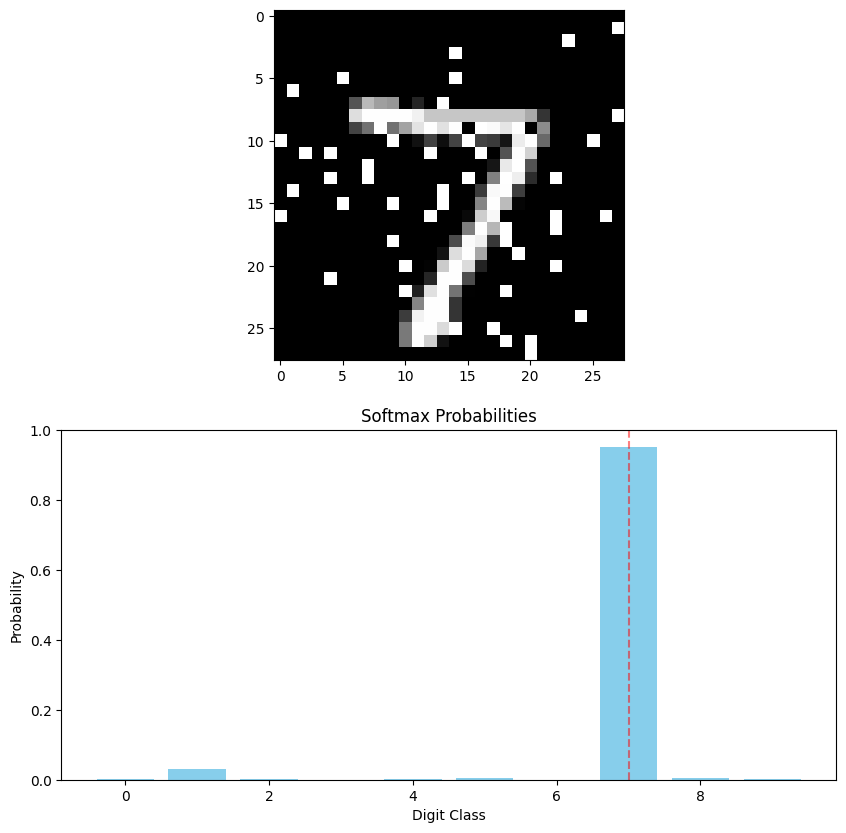

In [11]:
#run base model on example (noisy mnist sample)
image, label = next(iter(test_loader))
image, label = image.to(device), label.to(device)
output = mykfac.model(image)

probs = softmax(output, dim=1).cpu().detach().numpy().squeeze()
pred = output.argmax(dim=1).cpu()
print(f'predicion = {pred}')
fig, axes = plt.subplots(2, figsize=(10, 10))
axes[0].imshow(image[0].cpu().numpy().squeeze(), cmap = 'gray')
axes[1].bar(range(10), probs, color='skyblue')
axes[1].set_ylim(0, 1)
axes[1].set_title("Softmax Probabilities")
axes[1].set_xlabel("Digit Class")
axes[1].set_ylabel("Probability")
axes[1].axvline(x=pred, color='red', linestyle='--', alpha=0.5)

In [12]:
#GLM uncertainties

import copy

n_classes = 10
output = mykfac.model(image)

gradients = []
#compute gradient for every scalar outout (#via one backprop for every dimension in the output logit space)
for i in tqdm(range(n_classes)):
    out = output[0][i]
    mykfac.model.zero_grad()
    out.backward(retain_graph=True)
    mykfac.update_grad(log = False)
    gradients.append(copy.deepcopy(mykfac.grad))


output_vars = []
for grad in gradients:
    output_vars.append(my.kfac.kf_inner(grad, grad))
plt.plot(output_vars)
plt.xlabel("class label")


100%|██████████| 10/10 [00:00<00:00, 78.37it/s]


NameError: name 'my' is not defined

In [ ]:
#MC-GLM uncertainties

output = mykfac.model(image)
eps = 1e-6 #for numerical differentiation
mc_preds = []
iters = 16 #number of monte-carlo samples
with torch.no_grad():
    for i in tqdm(range(iters)):
        mykfac.sample_and_replace(eps = eps)
        output_logits_mc = mykfac.model(image)
        # print(output_logits_mc)
        mc_preds.append(output_logits_mc)

mc_output_stacked = torch.stack(mc_preds) # shape: (iters, n_classes)

A = (mc_output_stacked - output)/eps

B = torch.matmul(A.permute(1,2,0), A.permute(1,0,2)) #shape: (n_classes, n_classes)
print(torch.diagonal(B))
plt.plot(torch.diagonal(B).cpu().detach().numpy().squeeze())
plt.xlabel("class label")
plt.ylabel('uncertainty')


In [ ]:
#We can get the full 10 x 10 covariance matrix
plt.imshow(B.detach().cpu().numpy().squeeze())